### Deliverable 3: Optimization of Neural Network

In [1]:
# Attempt 1 drop ASK_AMT column as it is adding little value change leaky_relu to relu on hidden layer 2 => Accur 72.65
# Attempt 2 add third hidden layer => Accur 72.5
# Attemt 3 change APPLICATION_TYPE bucketing value to less than 500 counts as other. => Accur 72.4


In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

# Import checkpoint dependencies (note for deliverable 2 but put at top of the file for best practices)
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [3]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
# For optimization attempt 1 drop ASK_AMT as well
application_df.drop(columns=['EIN','NAME','ASK_AMT'],inplace=True)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,1


In [4]:
# Determine the number of unique values in each column.
# We will want to group together those with more than 10 values
object_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_df[object_cat].nunique()

APPLICATION_TYPE          17
AFFILIATION                6
CLASSIFICATION            71
USE_CASE                   5
ORGANIZATION               4
INCOME_AMT                 9
SPECIAL_CONSIDERATIONS     2
dtype: int64

In [5]:
# Look at APPLICATION_TYPE in more detail since it had 17 categories.  
# Need to decide how to potentially group fields into an other category
applicationtype_counts = application_df.APPLICATION_TYPE.value_counts()
applicationtype_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T14        3
T25        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

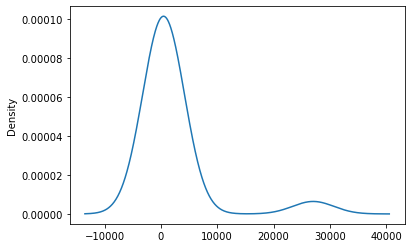

In [6]:
# Visualize the value counts of APPLICATION_TYPE
applicationtype_counts.plot.density()

In [7]:
# Determine which values in APPLICATION_TYPE we will group into an other category.
# Choose less than  528 counts will be binned to other.
# Optimization attempt 3 change 528 to 500
replace_application = list(applicationtype_counts[applicationtype_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [8]:
# Look at CLASSIFICATION in more detail since it had 71 categories.  
# Need to decide how to potentially group fields into an other category
applicationclassification_counts = application_df.CLASSIFICATION.value_counts()
applicationclassification_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C1728        1
C2170        1
C1580        1
C2570        1
C1248        1
Name: CLASSIFICATION, Length: 71, dtype: int64

<AxesSubplot:ylabel='Density'>

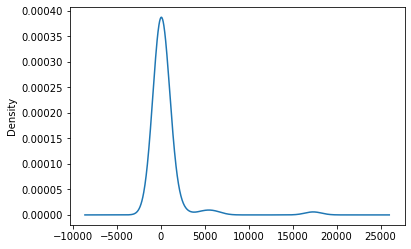

In [9]:
# Visualize the value counts of CLASSIFICATION
applicationclassification_counts.plot.density()

In [10]:
# Determine which values in CLASSIFICATION we will group into an other category.
# Choose less than  1883 counts will be binned to other.
replace_classification = list(applicationclassification_counts[applicationclassification_counts < 1883].index)

# Replace in dataframe
for cls in replace_classification:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [11]:
# Now generate our categorical variable lists which are the non-numeric column fields in our data
application_cat=application_df[object_cat].columns.to_list()
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [12]:
# Now use the OneHotEncoder to ecode our data.  This will create extra columns that have 1 or 0 
# for each category which our columns
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
# Merge one-hot encoded features and drop the original columns
application_df = application_df.merge(encode_df,left_index=True, right_index=True)
application_df = application_df.drop(application_cat,1)
application_df.head()

,STATUS,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [15]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Compile, Train and Evaluate the Model

In [16]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])

hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 15

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
# attempt 1 change to relu
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer added for optimziation attempt 3
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                3440      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 15)                465       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 6,351
Trainable params: 6,351
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
    period=5,)

In [19]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 807us/step - loss: 0.5708 - accuracy: 0.7224
Epoch 2/100
804/804 [==============================] - 1s 736us/step - loss: 0.5544 - accuracy: 0.7304
Epoch 3/100
804/804 [==============================] - 1s 731us/step - loss: 0.5521 - accuracy: 0.7310
Epoch 4/100
804/804 [==============================] - 1s 736us/step - loss: 0.5499 - accuracy: 0.7324
Epoch 5/100
768/804 [===========================>..] - ETA: 0s - loss: 0.5474 - accuracy: 0.7340
Epoch 00005: saving model to checkpoints\weights.05.hdf5
804/804 [==============================] - 1s 739us/step - loss: 0.5485 - accuracy: 0.7332
Epoch 6/100
804/804 [==============================] - 1s 756us/step - loss: 0.5485 - accuracy: 0.7328
Epoch 7/100
804/804 [==============================] - 1s 747us/step - loss: 0.5467 - accuracy: 0.7341
Epoch 8/100
804/804 [==============================] - 1s 725us/step - loss: 0.5469 - accuracy: 0.7332
Epoch 9/100
804/804 [=============

In [20]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5568 - accuracy: 0.7244 - 243ms/epoch - 907us/step
Loss: 0.5567935109138489, Accuracy: 0.7244315147399902


<AxesSubplot:>

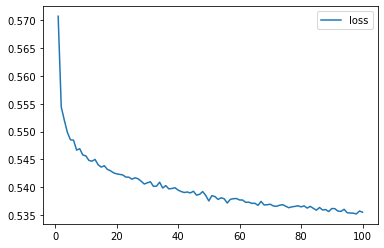

In [21]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

<AxesSubplot:>

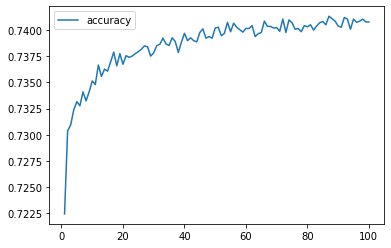

In [22]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [23]:
# Export our model to HDF5 file
nn.save("nn_model_saved/trained_attrition.h5")